In [1]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
from torch.utils.data import TensorDataset as ds

from sklearn.utils import shuffle

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [3]:

def copy_file(src_file, dst_dir):

    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    
    file_name = os.path.basename(src_file)
    dst_file = os.path.join(dst_dir, file_name)
    
    shutil.copy2(src_file, dst_file)
    print(f"Copied: {src_file} -> {dst_file}")


src_dir = "/mnt/home/bregaldosaintblancard/Projects/GalacticWavelets/output/cmass/v16"
file_name = "simbig.cmass_sgc.v16.1.1.0.npz"
src_file = os.path.join(src_dir, file_name)
dst_dir = "./downloaded_data"

try:
    copy_file(src_file, dst_dir)
    print("Copy completed successfully.")
except FileNotFoundError:
    print(f"Error: The file {src_file} was not found.")
except PermissionError:
    print(f"Error: Permission denied when trying to copy {src_file}.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Copied: /mnt/home/bregaldosaintblancard/Projects/GalacticWavelets/output/cmass/v16/simbig.cmass_sgc.v16.1.1.0.npz -> ./downloaded_data/simbig.cmass_sgc.v16.1.1.0.npz
Copy completed successfully.


In [4]:
data = np.load('downloaded_data/simbig.cmass_sgc.v16.1.1.0.npz')


x_train = data['x_train']

x_train = shuffle(x_train)

In [5]:
x_train.shape

(20000, 3677)

In [6]:
lim = int(len(x_train)*0.8)
train_data = x_train[:lim]
validation_data = x_train[lim:]

training_ds = ds(torch.from_numpy(train_data).to(torch.float32))
validation_ds = ds(torch.from_numpy(validation_data).to(torch.float32))

training_loader = dl(training_ds,batch_size=100,shuffle=True)
validation_loader = dl(validation_ds,batch_size=100,shuffle=True)

In [7]:
number_of_dimensions = 3677
base = nf.distributions.DiagGaussian((number_of_dimensions))

The following is setting up the architectures

In [8]:
#Real NVP Model here
def Real_nvp_init():
    num_layers = 185
    Real_NVP_flows = []
    for i in range(num_layers):
        parameters = nf.nets.MLP([1839,1838],init_zeros=True)
        Real_NVP_flows.append(nf.flows.AffineCouplingBlock(param_map=parameters,scale=False))
        Real_NVP_flows.append(nf.flows.Permute(2,mode="swap"))

    Real_NVP_model = nf.NormalizingFlow(q0=base,flows=Real_NVP_flows)

    return Real_NVP_model


In [9]:
#Neural Spline Flow
def Neural_Spline_init():
    K = 20
    torch.manual_seed(0)

    latent_size = number_of_dimensions
    hidden_units = 200
    hidden_layers = 2

    neural_flows = []
    for i in range(K):
        neural_flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        neural_flows += [nf.flows.LULinearPermute(latent_size)]


    Neural_Spline_model= nf.NormalizingFlow(q0=base, flows=neural_flows)

    return Neural_Spline_model

In [10]:
# def MAF_init():
#     MAF_flows = []
#     hidden = 256 #number of hidden units
    
#     latent_size = number_of_dimensions #input dimensions
    
#     K=5

#     for i in range(K):
#         MAF_flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden)]
#         MAF_flows += [nf.flows.Permute(number_of_dimensions,mode="shuffle")]

#     MAF_model = nf.NormalizingFlow(q0=base,flows=MAF_flows)

#     return MAF_model

# model = MAF_init()

In [11]:
def RotationalQuadraticSpline_init():
    K = 20

    latent_size = number_of_dimensions
    hidden_units = 200
    hidden_layers = 2

    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribution
    q0 = base
        
    # Construct flow model
    RotationalQuadraticSpline_model = nf.NormalizingFlow(q0, flows)

    return RotationalQuadraticSpline_model

Function for training the models

In [12]:
def train_model(model, learning_rate):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    tolerance = 0.0001
    previous_loss = float('inf')
    early_stop = False
    training_loss = []
    validation_loss=[]
    epochs = []
    for epoch in tqdm(range(150)):
        if not early_stop:
            model.train()
            for data in training_loader:
                optimizer.zero_grad()
                
                data = data[0].to(device)  # Extract data from TensorDataset and move to device
                loss = model.forward_kld(data)
                
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                
                current_loss = loss.item()
                
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                
            training_loss.append(loss.item())
            
            previous_loss = current_loss
        

            model.eval()
            with torch.no_grad():
                for val_data in validation_loader:
                    val_data = val_data[0].to(device)
                    val_loss = model.forward_kld(val_data)
            validation_loss.append(val_loss.item())

    plt.figure(figsize=(12,12))
    plt.plot(training_loss,label='training loss')
    plt.plot(validation_loss,label='validation Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

    return model,training_loss

training the models

In [13]:
Models = [Real_nvp_init(),Neural_Spline_init(),RotationalQuadraticSpline_init()]

trainable_parameters = []

for i in range(len(Models)):

    model_parameters = filter(lambda p: p.requires_grad, Models[i].parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    print(f'model has {params} trainable parameters')
    trainable_parameters.append(params)

model has 625662554 trainable parameters
model has 628390894 trainable parameters
model has 628390894 trainable parameters


 17%|█▋        | 25/150 [07:27<37:08, 17.83s/it]

Early stopping at epoch 26 with loss difference 0.000000


100%|██████████| 150/150 [07:43<00:00,  3.09s/it]


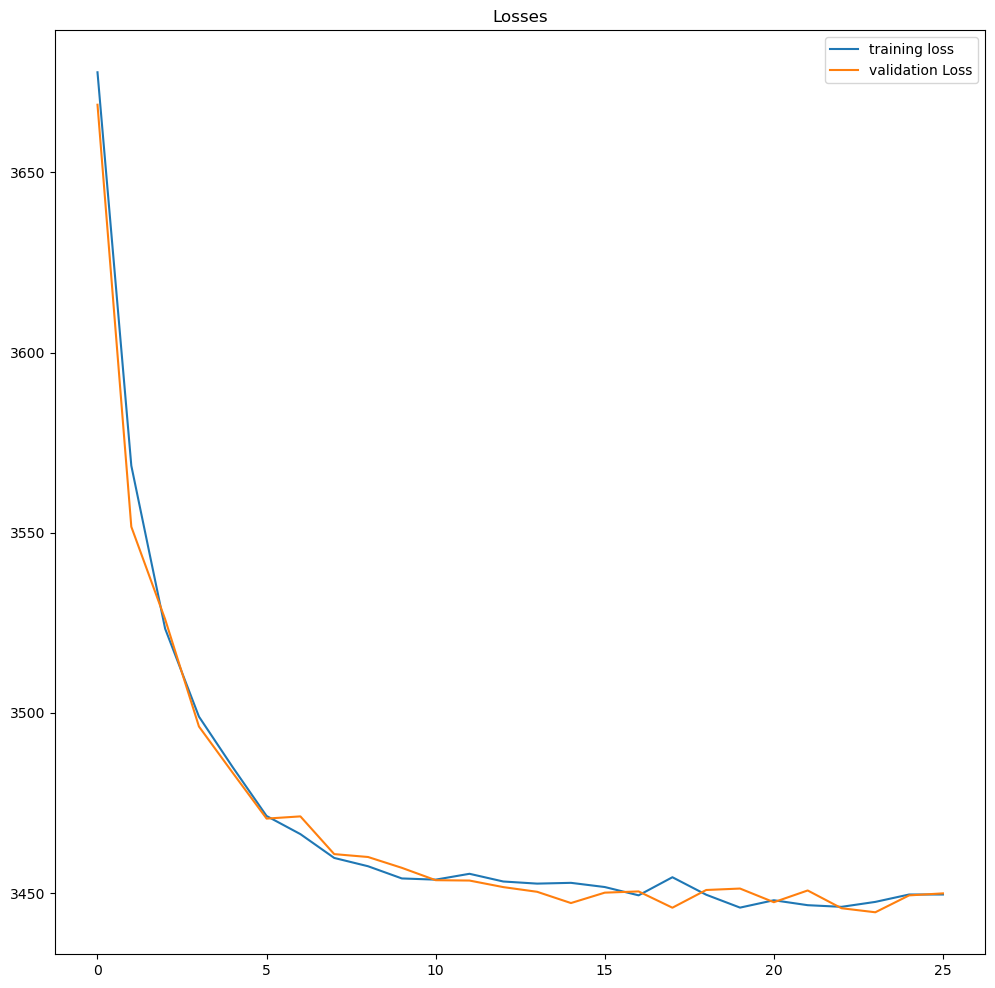

100%|██████████| 150/150 [7:12:34<00:00, 173.03s/it]  


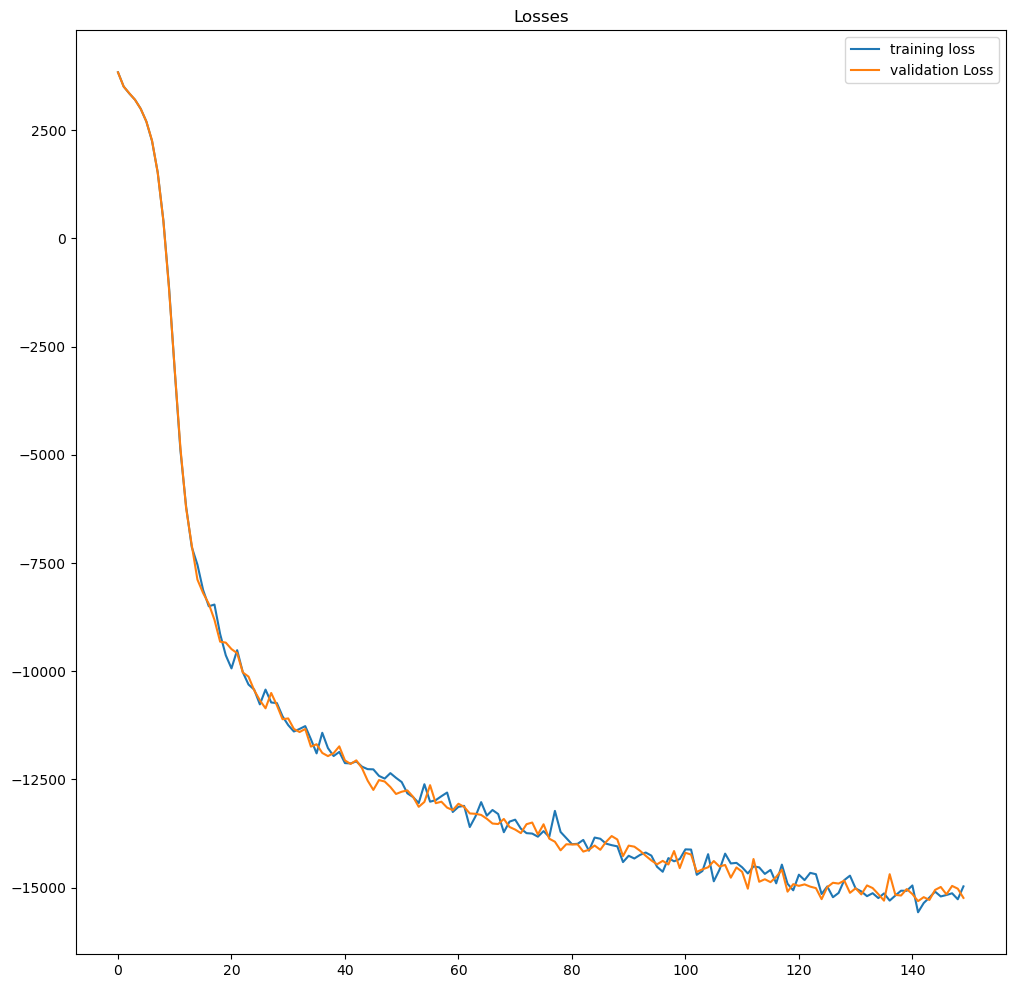

100%|██████████| 150/150 [7:07:09<00:00, 170.86s/it]  


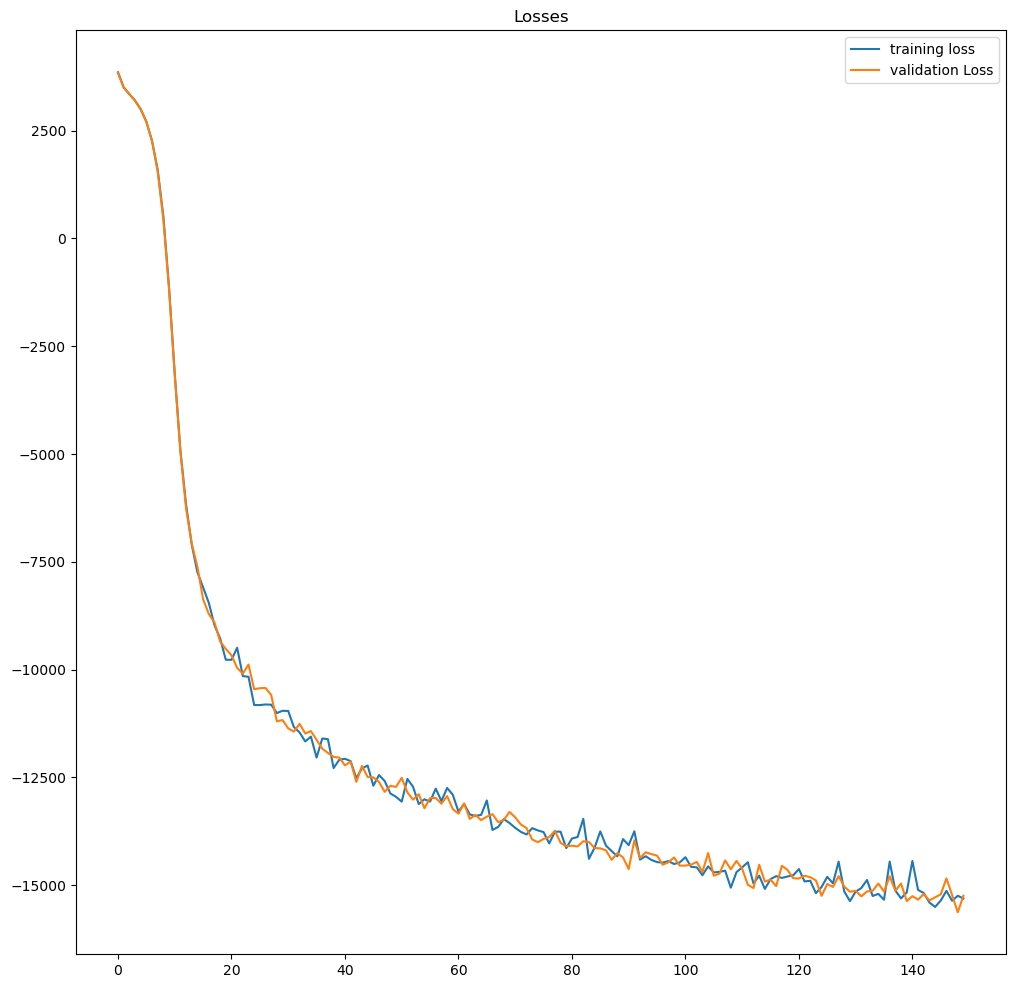

In [14]:
trained_models = []
losses=[]
rate = 1e-7 
for i in range(len(Models)):
    model,loss = train_model(Models[i],rate)
    trained_models.append(model)
    losses.append(loss)

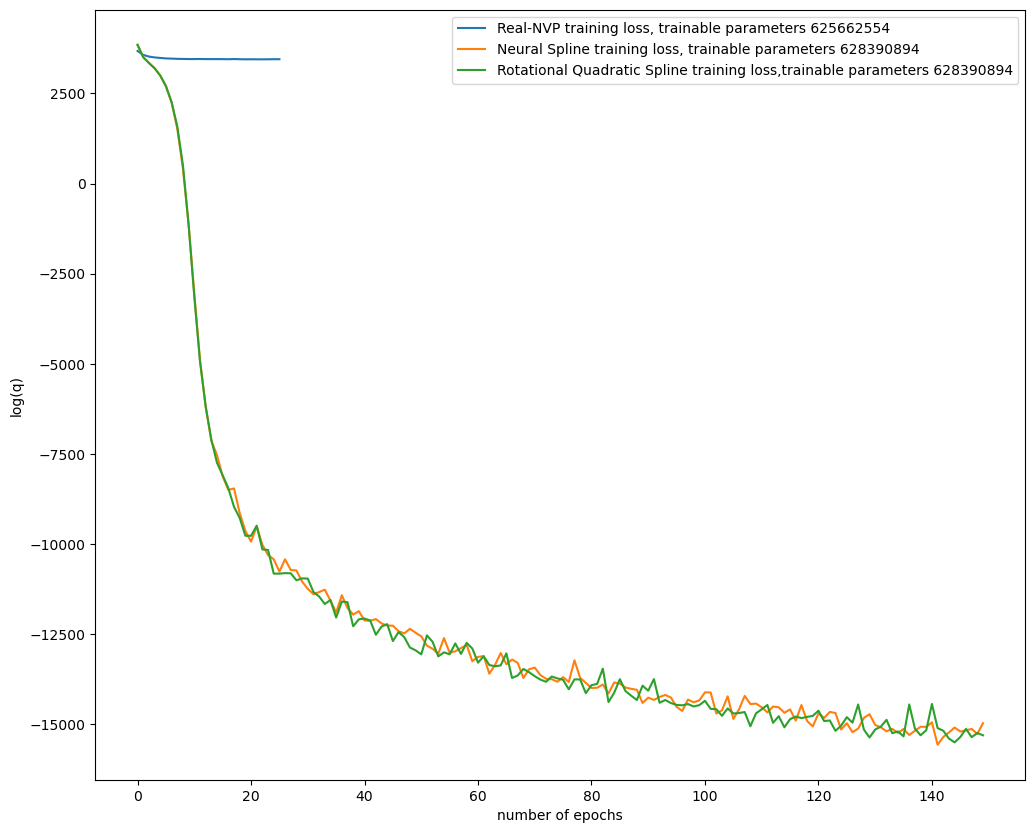

In [16]:
plt.figure(figsize=(12,10))
for i in range(len(losses)):
    if i==0:
        lab= f"Real-NVP training loss, trainable parameters {trainable_parameters[i]}"
    elif i==1:
        lab = f"Neural Spline training loss, trainable parameters {trainable_parameters[i]}"
    else:
        lab = f"Rotational Quadratic Spline training loss,trainable parameters {trainable_parameters[i]}"
    plt.plot(losses[i],label = lab)


plt.ylabel('log(q)')
plt.xlabel('number of epochs')
plt.legend()
plt.show()